# 7. 살사 (SARSA: State-Action-Reward-State-Action)

이번 챕터에서는 **시간차 학습(TD Learning)**의 대표적인 알고리즘인 **SARSA**를 실습한다.

### 시간차 학습 (TD Learning)

앞서 배운 몬테카를로(MC) 방법은 에피소드가 끝날 때까지 기다려야만 학습을 할 수 있었다. 반면, TD 학습은 **에피소드가 끝나지 않아도**, 한 스텝을 진행하고 얻은 보상과 다음 상태의 가치를 이용해 즉시 현재 상태의 가치를 업데이트한다. 이를 **부트스트랩(Bootstrapping)**이라고 한다.

### SARSA

SARSA는 **On-policy** TD 제어 기법이다. 현재 정책을 따라 행동()을 하고, 보상()을 받고, 다음 상태()로 이동한 뒤, 다시 현재 정책에 따라 다음 행동()을 선택한다. 이 과정의 데이터 $(S, A, R, S', A')$를 사용하여 학습하기 때문에 SARSA라는 이름이 붙었다.

업데이트 식은 다음과 같다.


### 0. 라이브러리 및 환경 설정

기존과 동일하게 `gymnasium`을 사용하며 미로 환경을 구성한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
# ---------------------------------------------------------
# 1. 커스텀 Maze 환경 정의 (Gymnasium 기반)
# ---------------------------------------------------------
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([5, 5]) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 0:Up, 1:Right, 2:Down, 3:Left
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        move = moves[action]
        next_state = np.clip(self.state + np.array(move), 0, 4)
        self.state = next_state

        terminated = np.array_equal(self.state, self.target)
        reward = -1.0
        if terminated:
            reward = 0.0

        return self.state, reward, terminated, False, {}

    def render(self):
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        grid[self.state[0], self.state[1]] = [0, 0, 255]
        grid[self.target[0], self.target[1]] = [0, 255, 0]
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

# 시각화 헬퍼 함수
def plot_action_values(action_values):
    values = np.max(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(values, cmap='coolwarm', interpolation='none')
    for r in range(5):
        for c in range(5):
            plt.text(c, r, f"{values[r, c]:.1f}", ha='center', va='center', color='black')
    plt.colorbar(label='Max Q-value')
    plt.title("Action Value Table (Max Q)")
    plt.show()

def plot_policy(action_values):
    best_actions = np.argmax(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.zeros((5, 5)), cmap='gray', vmin=0, vmax=1)
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
    for r in range(5):
        for c in range(5):
            if r == 4 and c == 4: continue
            action = best_actions[r, c]
            dx, dy = arrows[action]
            plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.grid(color='white')
    plt.title("Optimal Policy (Greedy)")
    plt.show()

---

## 1. SARSA 알고리즘 구현

SARSA의 핵심은 **현재 행동()을 실행한 후, 다음 상태()에서 할 다음 행동()까지 선택한 뒤에 업데이트**를 수행한다는 점이다.

In [3]:
# ---------------------------------------------------------
# 2. SARSA 알고리즘
# ---------------------------------------------------------

def sarsa(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Q-테이블 초기화
    q_table = np.zeros(shape=(5, 5, 4))

    for episode in range(episodes):
        state, _ = env.reset()

        # 1. 초기 행동 선택 (Epsilon-Greedy)
        if np.random.random() < epsilon:
            action = np.random.randint(4)
        else:
            action = np.argmax(q_table[state[0], state[1]])

        done = False

        while not done:
            # 2. 행동 실행 및 관측
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # 3. 다음 행동 선택 (On-policy: 현재 정책으로 다음 행동 A'를 미리 선택)
            if np.random.random() < epsilon:
                next_action = np.random.randint(4)
            else:
                next_action = np.argmax(q_table[next_state[0], next_state[1]])

            # 4. SARSA 업데이트 식 적용
            # Q(S, A) <- Q(S, A) + alpha * [R + gamma * Q(S', A') - Q(S, A)]

            # 현재 상태의 Q값
            curr_q = q_table[state[0], state[1], action]

            # 다음 상태의 Q값 (다음 행동 A'에 대한 값 사용)
            next_q = q_table[next_state[0], next_state[1], next_action]

            # 목표 지점에 도달했다면 다음 가치는 0
            if done:
                target = reward
            else:
                target = reward + gamma * next_q

            # 업데이트
            q_table[state[0], state[1], action] = curr_q + alpha * (target - curr_q)

            # 5. 상태 및 행동 변수 갱신
            state = next_state
            action = next_action

    return q_table

print("SARSA 알고리즘 정의 완료")

SARSA 알고리즘 정의 완료


---

## 2. 학습 실행

10,000 에피소드 동안 에이전트를 학습시킨다. SARSA는 MC와 달리 에피소드 중간에도 계속 학습이 이루어지므로, 일반적으로 더 효율적으로 수렴할 수 있다.

In [4]:
# 환경 생성
env = Maze()

print("학습 시작 (SARSA)...")
q_table = sarsa(env, episodes=10000, alpha=0.1, gamma=0.99, epsilon=0.1)
print("학습 완료!")

학습 시작 (SARSA)...
학습 완료!


---

## 3. 결과 시각화

학습된 가치 함수와 정책을 확인한다.

### 3.1 Q-Value 시각화

SARSA로 학습된 값들의 분포를 본다. 목표에 가까울수록 값이 높게 형성된다.

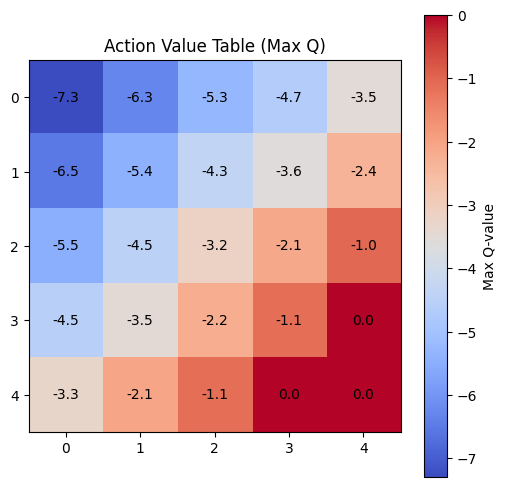

In [5]:
plot_action_values(q_table)

### 3.2 최적 정책 시각화

학습된 테이블을 바탕으로 가장 좋은 행동을 선택하는 정책을 시각화한다.

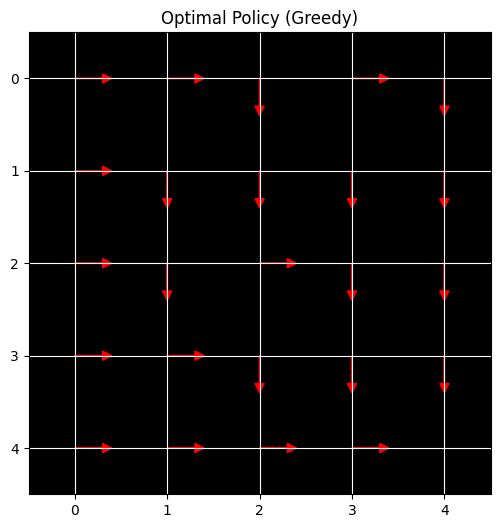

In [6]:
plot_policy(q_table)

### 3.3 에이전트 테스트

학습된 정책으로 에이전트가 목표를 잘 찾아가는지 시뮬레이션한다. 테스트 시에는 탐험() 없이 탐욕적(Greedy)으로만 행동한다.

테스트 종료


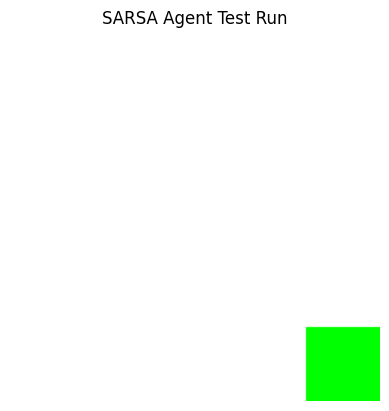

In [7]:
def test_agent(env, q_table):
    state, _ = env.reset()
    done = False
    step = 0
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("SARSA Agent Test Run")

    while not done and step < 20:
        # Greedy Action
        r, c = state
        action = np.argmax(q_table[r, c])

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1
    print("테스트 종료")

test_agent(env, q_table)

### 요약

SARSA는 자신이 선택한 다음 행동()까지 고려하여 값을 업데이트하는 안전한 학습 방식이다. 특히 잘못된 행동(탐험)을 했을 때 큰 페널티가 있는 환경에서는, 위험한 경로를 피하는 보수적인 정책을 학습하는 경향이 있다. 다음 챕터에서는 다음 행동을 고려하지 않고 최적의 가치만을 좇는 Q-Learning에 대해 다룰 예정이다.